In [1]:
import numpy as np
import pandas as pd
import os
import glob
import pickle as pkl
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
def parse_outs_to_dataframe(filename):
    input_text = open(filename).read()
    lines = input_text.split("\n")
    current_trial_group = None
    current_noise_level = None
    data = []
    
    for line in lines:
        if "Running trials for n =" in line:
            current_trial_group = tuple(map(int, re.findall(r'\d+', line)))
        elif "Cross validating alpha under noise level:" in line:
            current_noise_level = float(line.split()[-1])
        elif "Trial:" in line and current_trial_group and current_noise_level is not None:
            trial_info = re.findall(r'{.*?}', line)[0]
            trial_info = eval(trial_info)
            trial_info["Trial"] = int(line.split()[1])
            
            # Modified regular expression to handle scientific notation
            number_regex = r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?'
            
            trial_info["Lowest CV Error"] = float(re.findall(f'(?<=Lowest CV Error:  ){number_regex}', line)[0])
            trial_info["Training Error"] = float(re.findall(f'(?<=Training Error:  ){number_regex}', line)[0])
            trial_info["Testing Error"] = float(re.findall(f'(?<=Testing Error:  ){number_regex}', line)[0])
            trial_info["n"] = current_trial_group[0]
            trial_info["p"] = current_trial_group[1]
            trial_info["m"] = current_trial_group[2]
            trial_info["Noise Level"] = current_noise_level
            data.append(trial_info)
    
    df = pd.DataFrame(data)
    return df


In [3]:
out_dir = 'outputs/0719/'
out_files = glob.glob(out_dir + '*.out')
omp_out = []
bomp_out = []

for file_path in out_files:
    out_summary = parse_outs_to_dataframe(file_path)
    if 'best_bag' in out_summary.columns:
        bomp_out.append(out_summary)
    else:
        omp_out.append(out_summary)
omp_out_summary = pd.concat(omp_out).reset_index(drop=True)
bomp_out_summary = pd.concat(bomp_out).reset_index(drop=True)
omp_error_dataframe = (omp_out_summary[['n', 'p', 'm', 'Noise Level','Training Error', 'Testing Error']]).groupby(['n', 'p', 'm', 'Noise Level']).mean().reset_index()
bomp_error_dataframe = bomp_out_summary[['n', 'p', 'm', 'Noise Level','Training Error', 'Testing Error']].groupby(['n', 'p', 'm', 'Noise Level']).mean().reset_index()

In [4]:
# first we need to add prefixes to the column names of each dataframe
temp_omp_error_dataframe = omp_error_dataframe.copy().add_prefix('omp_')
temp_bomp_error_dataframe = bomp_error_dataframe.copy().add_prefix('bomp_')

# then we remove the prefix from the columns we will merge on
temp_omp_error_dataframe.rename(columns={'omp_n':'n', 'omp_p':'p', 'omp_m':'m', 'omp_Noise Level':'Noise Level'}, inplace=True)
temp_bomp_error_dataframe.rename(columns={'bomp_n':'n', 'bomp_p':'p', 'bomp_m':'m', 'bomp_Noise Level':'Noise Level'}, inplace=True)

# now we can merge
merged_df = pd.merge(temp_omp_error_dataframe, temp_bomp_error_dataframe, on=['n', 'p', 'm', 'Noise Level'], suffixes=('_omp', '_bomp'))

merged_df['testing_error_improvement'] = (merged_df['omp_Testing Error'] - merged_df['bomp_Testing Error'])/ merged_df['omp_Testing Error']
merged_df['training_error_improvement'] = (merged_df['omp_Training Error'] - merged_df['bomp_Training Error'])/ merged_df['omp_Training Error']


groups = merged_df.groupby(['n', 'p', 'm'])
list_of_groups = [groups.get_group(x) for x in groups.groups]

merged_df


,n,p,m,Noise Level,omp_Training Error,omp_Testing Error,bomp_Training Error,bomp_Testing Error,testing_error_improvement,training_error_improvement
0,300,500,10,0.02,0.015418,0.015201,0.000257,0.001435,0.905628,0.983322
1,300,500,10,0.04,0.016805,0.016448,0.000814,0.003755,0.771736,0.951582
2,300,500,10,0.06,0.018987,0.018522,0.001344,0.007577,0.590926,0.929221
3,300,500,10,0.08,0.021965,0.021421,0.003699,0.011308,0.472114,0.831612
4,300,500,10,0.10,0.025723,0.026213,0.003269,0.017836,0.319582,0.872916
5,300,500,10,0.22,0.064808,0.066490,0.007351,0.078600,-0.182140,0.886575
6,300,500,10,0.24,0.074104,0.076097,0.008472,0.092625,-0.217202,0.885674
7,300,500,10,0.26,0.084160,0.086367,0.009716,0.107489,-0.244552,0.884555
8,300,500,10,0.28,0.094965,0.101584,0.011338,0.123255,-0.213329,0.880606
9,300,500,10,0.30,0.106363,0.117259,0.012922,0.138228,-0.178825,0.878512


In [5]:
merged_df[['n','p','m','Noise Level','testing_error_improvement','training_error_improvement']]

,n,p,m,Noise Level,testing_error_improvement,training_error_improvement
0,300,500,10,0.02,0.905628,0.983322
1,300,500,10,0.04,0.771736,0.951582
2,300,500,10,0.06,0.590926,0.929221
3,300,500,10,0.08,0.472114,0.831612
4,300,500,10,0.10,0.319582,0.872916
5,300,500,10,0.22,-0.182140,0.886575
6,300,500,10,0.24,-0.217202,0.885674
7,300,500,10,0.26,-0.244552,0.884555
8,300,500,10,0.28,-0.213329,0.880606
9,300,500,10,0.30,-0.178825,0.878512


In [6]:
for group in list_of_groups:
    group.columns = group.columns.str.replace('Error', '')
    group.columns = group.columns.str.replace('_error', '')
    print(f"m = {group['m'].iloc[0]}")
    print(group.drop(columns=['n', 'p', 'm']).to_latex(index=False))

m = 10
\begin{tabular}{rrrrrrr}
\toprule
 Noise Level &  omp\_Training  &  omp\_Testing  &  bomp\_Training  &  bomp\_Testing  &  testing\_improvement &  training\_improvement \\
\midrule
        0.02 &       0.015418 &      0.015201 &        0.000257 &       0.001435 &             0.905628 &              0.983322 \\
        0.04 &       0.016805 &      0.016448 &        0.000814 &       0.003755 &             0.771736 &              0.951582 \\
        0.06 &       0.018987 &      0.018522 &        0.001344 &       0.007577 &             0.590926 &              0.929221 \\
        0.08 &       0.021965 &      0.021421 &        0.003699 &       0.011308 &             0.472114 &              0.831612 \\
        0.10 &       0.025723 &      0.026213 &        0.003269 &       0.017836 &             0.319582 &              0.872916 \\
        0.22 &       0.064808 &      0.066490 &        0.007351 &       0.078600 &            -0.182140 &              0.886575 \\
        0.24 &       0.0741

/var/folders/1w/nb8zzzyd2b19zfmmnsf651j00000gn/T/ipykernel_74325/3533740765.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(group.drop(columns=['n', 'p', 'm']).to_latex(index=False))
/var/folders/1w/nb8zzzyd2b19zfmmnsf651j00000gn/T/ipykernel_74325/3533740765.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(group.drop(columns=['n', 'p', 'm']).to_latex(index=False))


In [7]:
OMP_logs = glob.glob('outputs/0719/OMP*.pkl')
BOMP_logs = glob.glob('outputs/0719/BOMP*.pkl')
temp_BOMP_log = BOMP_logs[0]
with open(temp_BOMP_log, 'rb') as f:
    single_npm = pkl.load(f)[0]
single_npm_logs = single_npm['log']


In [8]:
single_npm['parameters']

{'n': 300,
 'p': 500,
 'm': 10,
 'noise_level_lst': [0.02, 0.04, 0.06, 0.08, 0.1],
 'model_name': 'BOMP',
 'cv_num': 5,
 'trial_num': 10,
 'param_grid': {'atom_bag_percent': [0.5, 0.7, 0.8, 0.9],
  'signal_bag_percent': [0.7, 0.8, 0.9]},
 'fixed_params': {'agg_func': 'weight',
  'ignore_warning': True,
  'random_seed': 1,
  'replace_flag': False,
  'select_atom_percent': 0,
  'Bag_lst': [1, 100, 200, 300, 400, 500],
  'K_lst': [1,
   10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   110,
   120,
   130,
   140,
   150,
   160,
   170,
   180,
   190,
   210,
   260]}}

In [9]:
single_npm['parameters']['fixed_params']

{'agg_func': 'weight',
 'ignore_warning': True,
 'random_seed': 1,
 'replace_flag': False,
 'select_atom_percent': 0,
 'Bag_lst': [1, 100, 200, 300, 400, 500],
 'K_lst': [1,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  210,
  260]}

In [10]:
lists_of_K_error_under_best_bag = []
for temp_single_npm_log in single_npm_logs:
    temp_bag_k_error_matrix = pd.DataFrame(temp_single_npm_log['best_bag_k_error_matrix'])
    temp_bag_k_error_matrix.columns = ['Bag', 'K', 'Best Predictor Error']
    K_error_under_best_bag = temp_bag_k_error_matrix[['K','Best Predictor Error']].groupby('K').min().reset_index()
    K_error_under_best_bag['noise_level'] = temp_single_npm_log['noise_level']
    K_error_under_best_bag['trial_id'] = temp_single_npm_log['trial']
    lists_of_K_error_under_best_bag.append(K_error_under_best_bag)
total_K_error_under_best_bag = pd.concat(lists_of_K_error_under_best_bag).reset_index(drop=True)

In [11]:
total_K_error_under_best_bag

,K,Best Predictor Error,noise_level,trial_id
0,1.0,0.018793,0.02,0
1,10.0,0.001378,0.02,0
2,20.0,0.001023,0.02,0
3,30.0,0.000905,0.02,0
4,40.0,0.000776,0.02,0
...,...,...,...,...
1095,170.0,0.200321,0.10,9
1096,180.0,6.533821,0.10,9
1097,190.0,6.782076,0.10,9
1098,210.0,205.995971,0.10,9


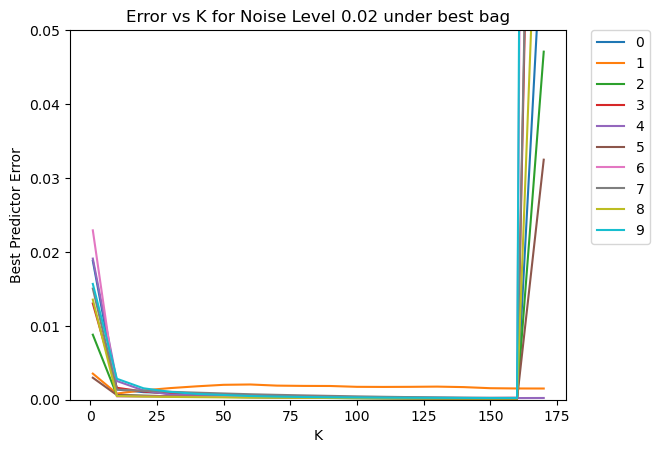

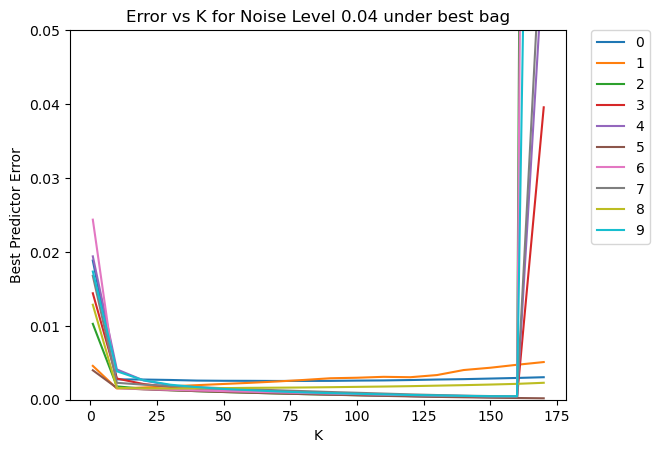

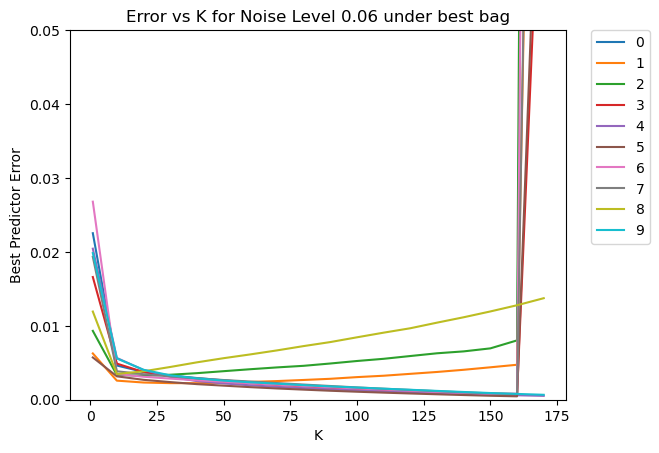

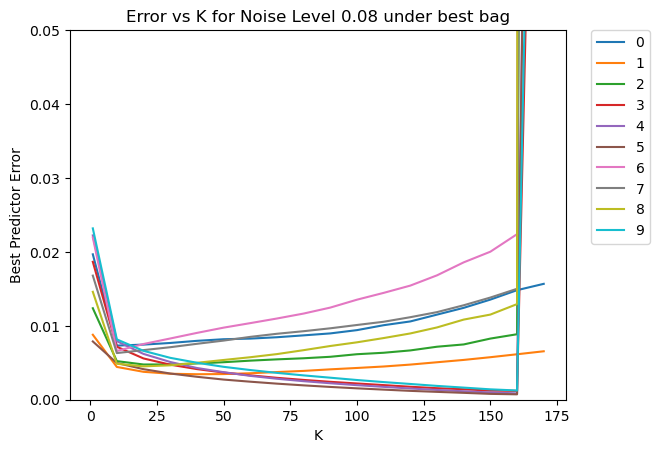

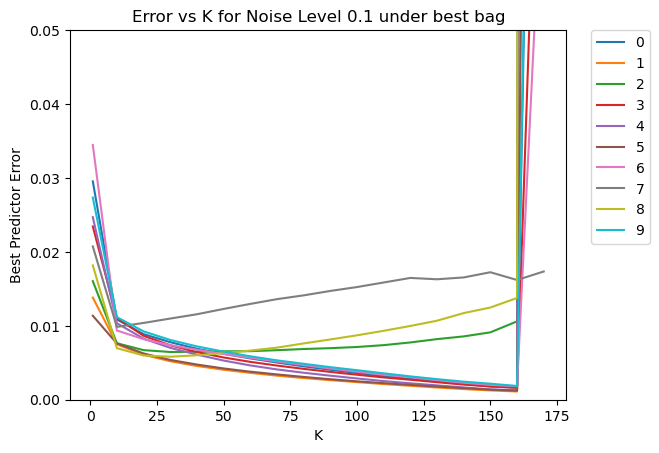

In [20]:
date_str = datetime.now().strftime("%m%d")

# Specify the directory where the figures will be saved
viz_dir = f"viz/{date_str}/"

# Check if the directory exists and if not, create it
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)


# List of unique noise levels
noise_levels = total_K_error_under_best_bag['noise_level'].unique()

# Generate a separate plot for each noise level
for noise_level in noise_levels:
    
    # Subset the dataframe for the current noise level
    df_subset = total_K_error_under_best_bag[(total_K_error_under_best_bag['noise_level'] == noise_level) & (total_K_error_under_best_bag['K'] <= 170)]
    # Create a new figure
    plt.figure()

    # Use seaborn to create a lineplot with multiple lines (one for each trial)
    sns.lineplot(data=df_subset, x='K', y='Best Predictor Error', hue='trial_id', palette='tab10')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(0, 0.05)
    # Customize the title and labels
    plt.title(f'Error vs K for Noise Level {noise_level} under best bag')
    plt.xlabel('K')
    plt.ylabel('Best Predictor Error')
    plt.savefig(os.path.join(viz_dir, f'Error_vs_K_for_Noise_Level_{noise_level}_under_best_bag.png'))
    # Display the plot
    plt.show()


'0720'

In [107]:
temp_single_npm_log

{'noise_level': 0.02,
 'trial': 0,
 'cv_error_lst': array([0.00465707, 0.00457625, 0.00538786, 0.07446459, 0.00254194,
        0.00242405, 0.00420301, 0.00393985, 0.00398022, 0.00234264,
        0.002639  , 0.00388725]),
 'lowest_cv_error': 0.0023426404292956884,
 'training_error': 0.00021393629319020616,
 'best_params': {'atom_bag_percent': 0.9,
  'signal_bag_percent': 0.7,
  'best_bag': 500,
  'best_k': 150},
 'param_lst': [{'atom_bag_percent': 0.5, 'signal_bag_percent': 0.7},
  {'atom_bag_percent': 0.5, 'signal_bag_percent': 0.8},
  {'atom_bag_percent': 0.5, 'signal_bag_percent': 0.9},
  {'atom_bag_percent': 0.7, 'signal_bag_percent': 0.7},
  {'atom_bag_percent': 0.7, 'signal_bag_percent': 0.8},
  {'atom_bag_percent': 0.7, 'signal_bag_percent': 0.9},
  {'atom_bag_percent': 0.8, 'signal_bag_percent': 0.7},
  {'atom_bag_percent': 0.8, 'signal_bag_percent': 0.8},
  {'atom_bag_percent': 0.8, 'signal_bag_percent': 0.9},
  {'atom_bag_percent': 0.9,
   'signal_bag_percent': 0.7,
   'best_b

In [81]:
temp_single_npm_log.keys()

dict_keys(['noise_level', 'trial', 'cv_error_lst', 'lowest_cv_error', 'training_error', 'best_params', 'param_lst', 'testing_error', 'best_bag_k_error_matrix'])

In [85]:
single_npm_Bag_lst = single_npm['parameters']['fixed_params']['Bag_lst']
single_npm_K_lst  = single_npm['parameters']['fixed_params']['K_lst']